In [43]:
import scipy.io
import numpy as np
from sklearn.metrics import auc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Extracting mean degree



In [44]:
hc_data_path = '/Users/jk1/unige_onedrive/OneDrive - unige.ch/BCT/atlas_BNA/BNA_240_flipped_N32_retroicor_SBB4_prop_bin_window/HC/Degrees240_binwin_HC.mat'
st_data_path = '/Users/jk1/unige_onedrive/OneDrive - unige.ch/BCT/atlas_BNA/BNA_240_flipped_N32_retroicor_SBB4_prop_bin_window/ST/Degrees240_binwin.mat'

In [45]:
outcome_var = 'mymeandegree_bin'
minimum_connectivity_threshold = 0.3

In [46]:
hc_data_mat = scipy.io.loadmat(hc_data_path)
st_data_mat = scipy.io.loadmat(st_data_path)

In [47]:
len(st_data_mat[outcome_var][0][0][0][0][0][0])

15

In [48]:
n_hc = len(hc_data_mat[outcome_var][0][0][0])
n_bins = len(hc_data_mat[outcome_var][0][0])
n_tp = 3

In [49]:
def parse_mat_file(data_mat, n_bins, outcome_var):
    # parsing matlab array to obtain (subj, bin)
    return np.moveaxis(
                np.squeeze([np.vstack(data_mat[outcome_var][0][0][bin_idx])
                                     for bin_idx in range(n_bins)]),
                0, -1)

In [50]:
hc_mean_degree = parse_mat_file(hc_data_mat, n_bins, outcome_var)
st_mean_degree = np.moveaxis(
                    np.squeeze([[np.vstack(st_data_mat[outcome_var][0][0][tp][0][0][bin_idx])
                                                     for bin_idx in range(n_bins)]
                                                        for tp in range(n_tp)]),
                    1, 2)

In [51]:
# correct for missing values - (pt1 TP1, pt5 Tp2, Pt13 (=pt17) TP3)
st0_md_corr = np.insert(st_mean_degree[0], 0, np.full((n_bins), np.NaN), axis=0)
st1_md_corr = np.insert(st_mean_degree[1], 4, np.full((n_bins), np.NaN), axis=0)
st2_md_corr = np.insert(st_mean_degree[2], 12, np.full((n_bins), np.NaN), axis=0)

st_mean_degree = np.array([st0_md_corr, st1_md_corr, st2_md_corr])

In [52]:
# use auc only over predefined area of thresholds
def custom_auc(values_over_thresholds):
    # only analyse thresholds above minimum_connectivity_threshold
    minimum_connectivity_threshold_index = int(minimum_connectivity_threshold*10)  - 1 # here thresholds start at bin1
    connectivity_thresholds = np.arange(minimum_connectivity_threshold, 1.1, 0.1)

    return auc(connectivity_thresholds,
                values_over_thresholds[minimum_connectivity_threshold_index:])

In [53]:
# take integral AUC over [0.3-1.0] interval
hc_mean_degree_auc = np.apply_along_axis(custom_auc, arr=hc_mean_degree, axis=1)
st_mean_degree_auc = np.apply_along_axis(custom_auc, arr=st_mean_degree, axis=-1)

In [54]:
hc_mean_degree_auc_df = pd.DataFrame(hc_mean_degree_auc, columns=['mean_degree_auc']).rename_axis('subject').reset_index()
hc_mean_degree_auc_df['group'] = 'hc'
hc_mean_degree_auc_df['timepoint'] = 0

st_mean_degree_auc_df = pd.DataFrame(st_mean_degree_auc).rename_axis('timepoint').reset_index()\
                                .melt(id_vars="timepoint", value_name='mean_degree_auc', var_name="subject")
st_mean_degree_auc_df["subject"] += n_hc
st_mean_degree_auc_df['group'] = 'st'


In [55]:
minimum_connectivity_threshold_index = int(minimum_connectivity_threshold*10)  - 1 # here thresholds start at bin1

hc_mean_degree_df = pd.DataFrame(hc_mean_degree[:, minimum_connectivity_threshold_index:])\
                    .rename_axis('subject').reset_index()\
                    .melt(id_vars=['subject'], var_name='density_bin', value_name='mean_degree')
hc_mean_degree_df['group'] = 'hc'
hc_mean_degree_df['timepoint'] = 0

In [56]:
st0_md_corr_df = pd.DataFrame(st0_md_corr[:, minimum_connectivity_threshold_index:])\
                    .rename_axis('subject').reset_index()\
                    .melt(id_vars=['subject'], var_name='density_bin', value_name='mean_degree')
st0_md_corr_df['timepoint'] = 0

st1_md_corr_df = pd.DataFrame(st1_md_corr[:, minimum_connectivity_threshold_index:])\
                    .rename_axis('subject').reset_index()\
                    .melt(id_vars=['subject'], var_name='density_bin', value_name='mean_degree')
st1_md_corr_df['timepoint'] = 1

st2_md_corr_df = pd.DataFrame(st2_md_corr[:, minimum_connectivity_threshold_index:])\
                    .rename_axis('subject').reset_index()\
                    .melt(id_vars=['subject'], var_name='density_bin', value_name='mean_degree')
st2_md_corr_df['timepoint'] = 2

st_mean_degree_df = pd.concat([st0_md_corr_df, st1_md_corr_df, st2_md_corr_df])
st_mean_degree_df['group'] = 'st'
st_mean_degree_df["subject"] += n_hc

In [57]:
all_mean_degree_auc_df = pd.concat([hc_mean_degree_auc_df, st_mean_degree_auc_df],
                                ignore_index=True)

# convert auc to numeric
all_mean_degree_auc_df['mean_degree_auc'] = all_mean_degree_auc_df['mean_degree_auc'].astype('float')


In [58]:
all_mean_degree_df = pd.concat([hc_mean_degree_df, st_mean_degree_df],
                                ignore_index=True)

all_mean_degree_df['density_bin'] += 3 # correct density bin indexing

# convert auc to numeric
all_mean_degree_df['mean_degree'] = all_mean_degree_df['mean_degree'].astype('float')

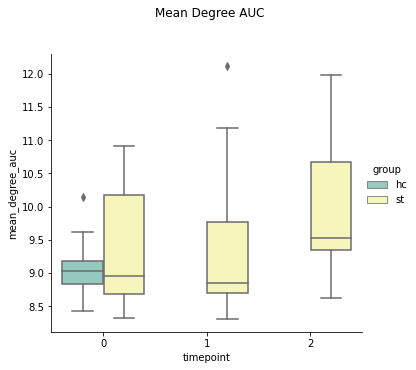

In [59]:
ax = sns.catplot(x="timepoint", y="mean_degree_auc", hue="group",
            kind='box', dodge=True,
            data=all_mean_degree_auc_df, palette="Set3"
                )
ax.fig.suptitle('Mean Degree AUC')
ax.fig.subplots_adjust(top=0.85)
plt.show()

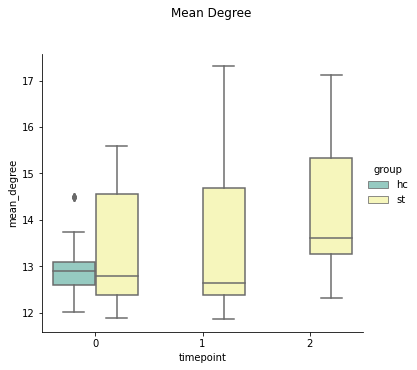

In [60]:
ax = sns.catplot(x="timepoint", y="mean_degree", hue="group",
            kind='box', dodge=True,
            data=all_mean_degree_df, palette="Set3"
                )
ax.fig.suptitle('Mean Degree')
ax.fig.subplots_adjust(top=0.85)
plt.show()


In [61]:
all_mean_degree_df.to_csv('mean_degree_df.csv', index=False)
all_mean_degree_auc_df.to_csv('mean_degree_auc_df.csv', index=False)

## Correlating mean degree to Eglob

In [62]:
global_efficiency_auc_df = pd.read_csv('glob_eff_auc_df.csv')

In [63]:
overall_df = global_efficiency_auc_df.merge(all_mean_degree_auc_df, on=['subject', 'group', 'timepoint'], how="inner")

In [64]:
overall_df['mean_degree_auc'].corr(overall_df['glob_eff_auc'], method="spearman")

0.8978847170809096